# Mathematics - Code for graded exercises

## 1. Determinant


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import timeit
import time

### 1.a Recursive calculation with Laplace definition

Let $A = [a_{ij}] \in \mathbb{R}^{n \times n}$, then (expansion for row $i$):

$$
\large |A| = \sum_{j=1}^{n} (-1)^{i+j} \, a_{ij} \cdot |M_{ij}|
$$

where $M_{ij}$ is the minor result of eliminating row $i$ and column $j$

In [2]:
def recursive_determinant(a: np.ndarray) -> np.float64:
    if len(a.shape) != 2:
        raise ValueError("Input is not a matrix")
    n, n0 = a.shape
    if n != n0:
        raise ValueError("Input matrix is not square")
    
    if n == 1:
        return a[0, 0]
    elif n == 2:
        return a[0, 0] * a[1, 1] - a[0, 1] * a[1, 0]
    
    first_row_minors_determinants = np.vectorize(
        lambda j: recursive_determinant(np.delete(a[1:, :], j, axis = 1))
    )(np.arange(n))

    signs = np.full((n), fill_value = -1) ** np.arange(n)
    return np.sum(a[0, :] * signs * first_row_minors_determinants)


Computational cost calculation:

$$
\large
T(n) = n \cdot T(n - 1) + O(n) \\[1em]
T(1) = O(1)
$$

Cost is given by the recurring equation $a_n = n a_{n-1} + n$, which expanded looks like:

$$
\large
\begin{align*}
a_n &= n a_{n-1} + n \\
    &= n \left( (n-1) a_{n-2} + (n-1) \right) + n \\
    &= n(n-1) a_{n-2} + n(n-1) + n \\
    &= n(n-1)\left((n-2) a_{n-3} + (n-2) \right) + n(n-1) + n \\
    &= n(n-1)(n-2) a_{n-3} + n(n-1)(n-2) + n(n-1) + n \\
    &\;\;\vdots \\
    &= n! a_1 + \sum_{k=1}^{n} k!
\end{align*}
$$

Therefore:

$$
\large
T(n) = O(n!)
$$

### 1.b Calculation with Gauss elimination

In [3]:
def gauss_determinant(a: np.ndarray) -> np.float64:
    if len(a.shape) != 2:
        raise ValueError("Input is not a matrix")
    n, n0 = a.shape
    if n != n0:
        raise ValueError("Input matrix is not square")
    
    a = a.copy()
    # Counts the number of row swaps
    sign = 1

    for i in range(n):
        # Search for the pivot in the i-th column
        #       removing the i-th first rows
        pivot = i + np.argmax(np.abs(a[i:, i]))
        if np.isclose(a[pivot, i], 0):
            # Singular matrix
            return np.float64(0) 

        # Swap rows if pivot is not in the i-th row
        #       i-th row <--> pivot-th row
        if pivot != i:
            a[[i, pivot]] = a[[pivot, i]]
            sign *= -1

        # Elimination -- substracts the remaining rows (i + 1, i + 2, ..., n)
        #   by the i-th row multiplied by a scalar, so that the i-th column
        #   has all zeros under the i-th position
        for j in range(i + 1, n):
            factor = a[j, i] / a[i, i]
            a[j, i:] -= factor * a[i, i:]

    # Determinant can be calculated by multiplying the diagonal
    return sign * np.prod(np.diag(a))

Computational cost calculation:

For every row $i$, ($O(n)$), the following operations are done: 

1. Search for pivot: $n - i$ elemental operations -> $O(n)$
2. Check if pivot is $0$: 1 elemental operation -> $O(1)$
3. Swap row $i$ with pivot row:

    - best case: 1 elemental operation -> $O(1)$
    - worst case: $3n + 1$ elemental operations -> $O(n)$

4. Elimination: $n - i$ row subtractions and multiplications -> $O(n^2)$

Finally, the diagonal elements are multiplied -> $O(n)$

Therefore:

$$
\large
T(n) = O(n^3)
$$

### 1.c Comparison

With one another and numpy.linalg.det

In [4]:
def compare_determinant_calculation_times(n: int) -> tuple[float, float, float]:
    a = np.random.rand(n, n)

    time_recursive = timeit.timeit(lambda: recursive_determinant(a), number = 1)
    time_gauss = timeit.timeit(lambda: gauss_determinant(a), number = 1)
    time_numpy = timeit.timeit(lambda: np.linalg.det(a), number = 1)

    return time_recursive, time_gauss, time_numpy


# Repetitions for every matrix size value 
n_values_repeat = {
    2: 2_500, 3: 2_500, 4: 2_000, 
    5: 1_000, 6: 250, 
    7: 50, 8: 10, 9: 3, 10: 1
}

times_df = pd.DataFrame(
    np.zeros(shape = (sum(n_values_repeat.values()), 4)),
    columns = [ "N value", "Recursive", "Gauss", "Numpy" ]
).astype({ "N value": np.int64 })



times_df_row = 0
start = time.time()

for n, repeat in n_values_repeat.items():
    for i in range(repeat):
        times_df.loc[times_df_row + i, :] = (n, ) + compare_determinant_calculation_times(n)
    times_df_row += repeat

    print(f"(n = {n}) Elapsed: {time.time() - start:.3f} s")
    start = time.time()

(n = 2) Elapsed: 7.623 s
(n = 3) Elapsed: 7.673 s
(n = 4) Elapsed: 6.470 s
(n = 5) Elapsed: 4.768 s
(n = 6) Elapsed: 3.340 s
(n = 7) Elapsed: 3.982 s
(n = 8) Elapsed: 7.095 s
(n = 9) Elapsed: 21.464 s
(n = 10) Elapsed: 112.380 s


Recursive               Gauss               Numpy          
               mean       std      mean       std      mean       std
N value                                                              
2          0.000009  0.000008  0.000147  0.000092  0.000040  0.000069
3          0.000157  0.000086  0.000162  0.000103  0.000035  0.000025
4          0.000399  0.000169  0.000167  0.000081  0.000031  0.000013
5          0.001685  0.000593  0.000202  0.000109  0.000036  0.000023
6          0.010041  0.001187  0.000237  0.000125  0.000039  0.000019
7          0.076179  0.005454  0.000272  0.000138  0.000039  0.000012
8          0.705801  0.032273  0.000284  0.000099  0.000039  0.000007
9          7.150366  0.167972  0.000399  0.000216  0.000045  0.000010
10       112.371664       NaN  0.001014       NaN  0.000134       NaN

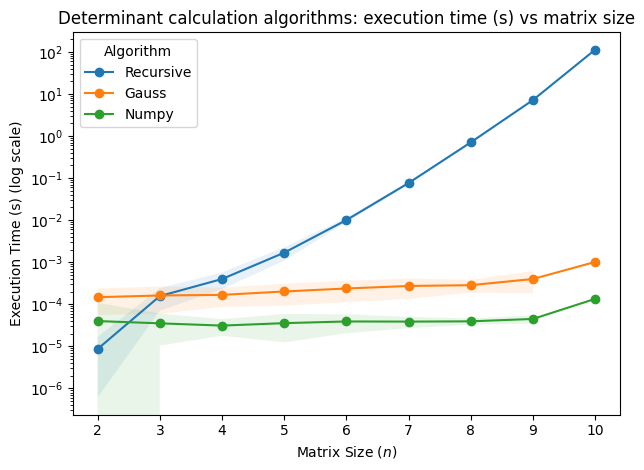

In [5]:
# Aggregate for repetitions and calculate mean and std
times_df_agg = times_df.groupby("N value").agg({ 
    "Recursive": ["mean", "std"], 
    "Gauss": ["mean", "std"], 
    "Numpy": ["mean", "std"] 
})
display(times_df_agg)

# Remove multi-index
times_df_agg = times_df_agg.reset_index()
times_df_agg.columns = ['N value'] + [ f"{algo}_{metric}" for algo, metric in times_df_agg.columns[1:] ]

# Graph
# plt.figure(figsize = (10, 6))
for algorithm in [ "Recursive", "Gauss", "Numpy" ]:
    plt.plot(times_df_agg["N value"], times_df_agg[f"{algorithm}_mean"], label = algorithm, marker = "o")
    plt.fill_between(
        times_df_agg["N value"],
        times_df_agg[f"{algorithm}_mean"] - times_df_agg[f"{algorithm}_std"],
        times_df_agg[f"{algorithm}_mean"] + times_df_agg[f"{algorithm}_std"],
        alpha = 0.1
    )

plt.title("Determinant calculation algorithms: execution time (s) vs matrix size")
plt.xlabel("Matrix Size ($n$)")
plt.ylabel("Execution Time (s) (log scale)")
plt.legend(title = "Algorithm")
plt.yscale("log")
plt.tight_layout()
plt.show()


## 2. Gradient descent

In [6]:
import numpy as np
from typing import Callable
from functools import partial
import matplotlib.pyplot as plt



def gradient_descent(
    grad_f: Callable[[np.ndarray], np.ndarray],
    x_0: np.ndarray,
    gamma: float,
    tol: float,
    maxit: int
) -> tuple[np.ndarray, str]:
    """
    Gradient descent method for minimizing a function of n variables.
    """

    x = x_0.copy()
    x_list = [ x.copy() ]
    for _ in range(maxit):
        grad = grad_f(x)
        if np.linalg.norm(grad) < tol:
            break
        x -= gamma * grad
        x_list.append(x.copy())
        if any(np.isnan(x) | np.isinf(x)):
            return np.array(x_list), "Gradient descent diverged"
        
    return np.array(x_list), ""


gradient_descent_partial = partial(gradient_descent, tol = 1e-12, maxit = 100_000)

### 2.1 Test gradient descent for a single variable function

Let $f : \mathbb{R} \rightarrow \mathbb{R}$

$$
\large f(x) = 3x^4 + 4x^3 - 12x^2 + 7.
$$
$$
\large  \frac{d}{dx} f(x) = 12x^3 + 12x^2 - 24x.
$$

In [7]:
def f(x: np.ndarray) -> np.ndarray:
    val = 3 * x[0]**4 + 4 * x[0]**3 - 12 * x[0]**2 + 7
    return np.array([val])

def grad_f(x: np.ndarray) -> np.ndarray:
    val = 12 * x[0]**3 + 12 * x[0]**2 - 24 * x[0]
    return np.array([val])

In [8]:
def plot_gradient_descent_f(gd_x: np.ndarray) -> None:
    # Filter x values over 100 in magnitude
    gd_x = gd_x[np.abs(gd_x[:, 0]) < 100, :]

    x_delta = np.abs([gd_x.min(), gd_x.max(), 3]).max()
    x_range = np.linspace(-x_delta, x_delta, 400)
    y_range = np.vectorize(lambda x: f(np.array([ x ])))(x_range)
    gd_y = np.vectorize(lambda x: f(np.array([ x ])))(gd_x)


    plt.figure(figsize = (8, 6))
    plt.plot(x_range, y_range, label = "$f(x)$", color = "blue")
    plt.scatter(gd_x, gd_y, s = 20, color = "blue", label = "Gradient descent steps")
    plt.quiver(
        gd_x[:-1, 0], gd_y[:-1, 0] + 20, np.diff(gd_x[:, 0]), np.diff(gd_y[:, 0]),
        angles = "xy", scale_units = "xy", scale = 1,
        color = "green", width = 0.005,
        label = "Descent direction"
    )

    plt.title("Gradient Descent on $f(x)$")
    plt.xlabel("$x$")
    plt.ylabel("$f(x)$")
    plt.legend(loc = "upper center")
    plt.grid(True)
    plt.show()


def gradient_descent_f(x_0: np.ndarray, gamma: float) -> None:
    gd_x, error = gradient_descent_partial(
        grad_f = grad_f,
        x_0 = x_0, 
        gamma = gamma
    )
    if not error:
        print(f"Gradient descent reached min with gamma = {gamma} for x = {gd_x[-1][0]}")
    else:
        print(f"{error} for gamma = {gamma}")
        
    plot_gradient_descent_f(gd_x)


Starting :

$$ \large x_0 = 3$$


For $\gamma$ values:

$$ \large \gamma = 0.001  \quad  \gamma = 0.01  \quad  \gamma = 0.1 $$

Gradient descent reached min with gamma = 0.001 for x = 1.0000000000000275


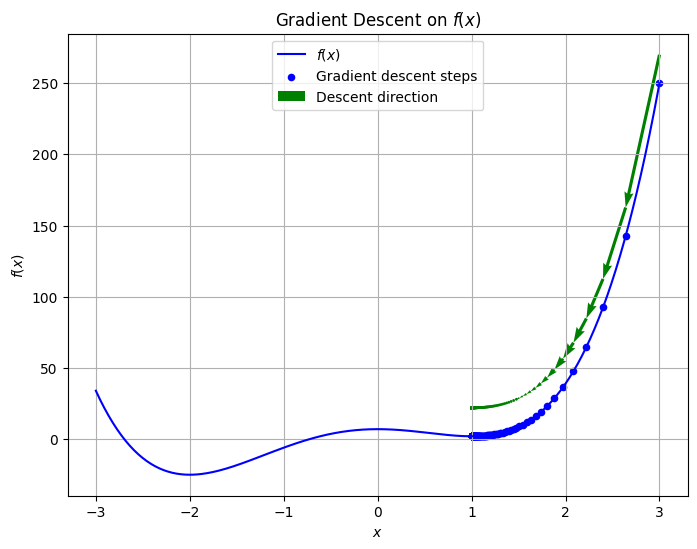

Gradient descent reached min with gamma = 0.01 for x = -1.9999999999999882


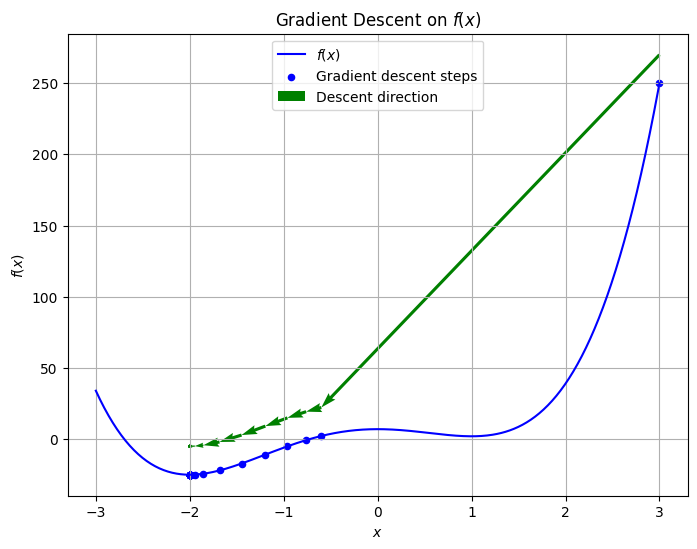

Gradient descent diverged for gamma = 0.1


C:\Users\Alfonso\AppData\Local\Temp\ipykernel_12428\2890475952.py:6: RuntimeWarning: overflow encountered in scalar power
  val = 12 * x[0]**3 + 12 * x[0]**2 - 24 * x[0]


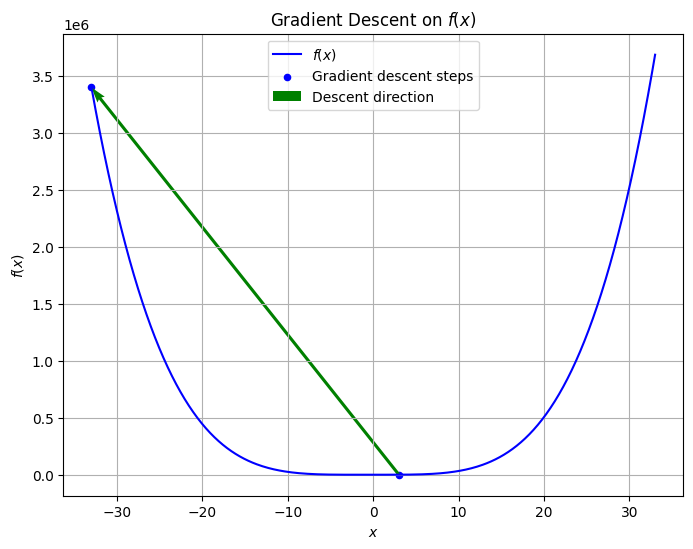

In [9]:
gradient_descent_f(np.array([3.0]), 0.001)
gradient_descent_f(np.array([3.0]), 0.01)
gradient_descent_f(np.array([3.0]), 0.1)

Now we change the parameters to:

$$ \large x_0 = 0  \quad  \gamma = 0.001 $$

Gradient descent reached min with gamma = 0.001 for x = 0.0


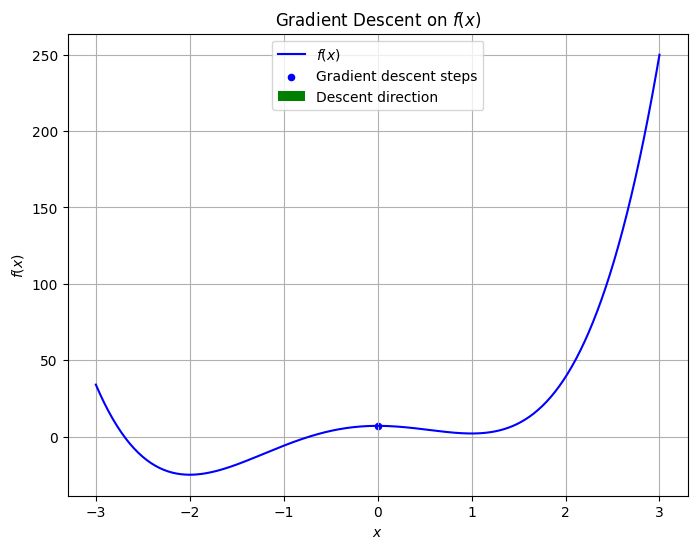

In [10]:
gradient_descent_f(np.array([0.0]), gamma = 0.001)

### 2.2 Test gradient descent for a bivariate function

Let $g : \mathbb{R}^2 \rightarrow \mathbb{R}$

$$
\large g(x, y) = x^2 + y^3 + 3xy + 1.
$$
$$
\large 
\nabla g(x, y) =
\begin{bmatrix}
2x + 3y \\
3y^2 + 3x
\end{bmatrix}
$$

In [11]:
def g(x: np.ndarray) -> np.ndarray:
    val = x[0]**2 + x[1]**3 + 3 * x[0] * x[1] + 1
    return np.array([val])

def grad_g(x: np.ndarray) -> np.ndarray:
    g_x = 2 * x[0] + 3 * x[1]
    g_y = 3 * x[1]**2 + 3 * x[0]
    return np.array([ g_x, g_y ])

In [12]:
def plot_gradient_descent_g(gd_x: np.ndarray) -> None:
    x_min, x_max = np.floor(gd_x[:, 0].min()) - 0.1, np.ceil(gd_x[:, 0].max()) + 0.1
    y_min, y_max = np.floor(gd_x[:, 1].min()) - 0.1, np.ceil(gd_x[:, 1].max()) + 0.1

    x_values = np.linspace(x_min, x_max, 400)
    y_values = np.linspace(y_min, y_max, 400)
    x, y = np.meshgrid(x_values, y_values)
    z = np.array([
        [ 
            g(np.array([x, y]))[0] 
            for x in x_values
        ]
        for y in y_values
    ])

    plt.figure(figsize = (8, 6))
    # Heatmap
    plt.contourf(x, y, z, levels = 50, cmap = "coolwarm", alpha = 0.8)
    plt.colorbar(label = "$g(x, y)$")

    if len(gd_x) < 10:
        plt.scatter(gd_x[:, 0], gd_x[:, 1], s = 20, color = "blue")

    # Green arrows
    subset = np.arange(0, len(gd_x)) % 10 == 0
    dx = np.diff(gd_x[subset, 0])
    dy = np.diff(gd_x[subset, 1])
    plt.quiver(
        gd_x[subset, 0][:-1], gd_x[subset, 1][:-1], dx, dy,
        angles = "xy", scale_units = "xy", scale = 1,
        color = "green", width = 0.005
    )

    plt.suptitle("Gradient Descent on $g(x, y)$")
    plt.title(f"Interval represented: ({x_min}, {x_max})x({y_min}, {y_max})")    
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.show()


def gradient_descent_g(x_0: np.ndarray, gamma: float) -> None:
    gd_x, error = gradient_descent_partial(
        grad_f = grad_g,
        x_0 = x_0, 
        gamma = gamma
    )
    if not error:
        print(f"Gradient descent reached min with gamma = {gamma} for (x, y) = ({gd_x[-1][0]}, {gd_x[-1][1]})")
    else:
        print(f"{error} for gamma = {gamma}")
    plot_gradient_descent_g(gd_x)

Parameters:

$$ \large x_0 = (-1, 1)  \quad  \gamma = 0.01 $$

Gradient descent reached min with gamma = 0.01 for (x, y) = (-2.2499999999989475, 1.4999999999996108)


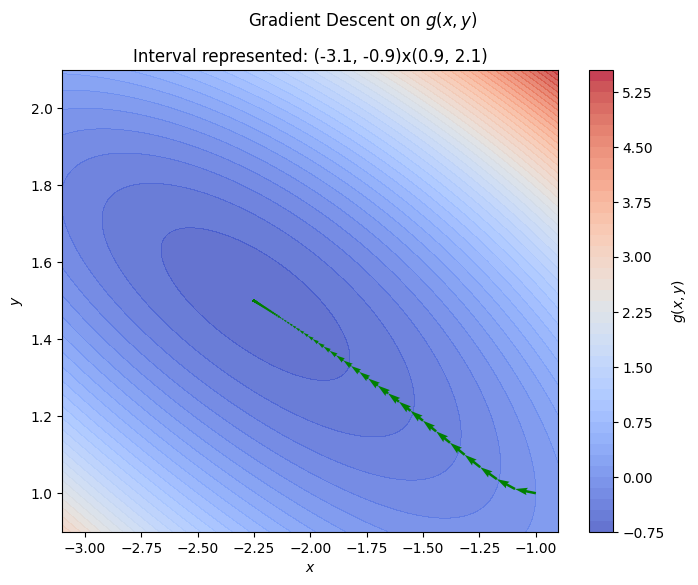

In [13]:
gradient_descent_g(np.array([-1.0, 1.0]), 0.01)

Parameters:

$$ \large x_0 = (0, 0)  \quad  \gamma = 0.01 $$

Gradient descent reached min with gamma = 0.01 for (x, y) = (0.0, 0.0)


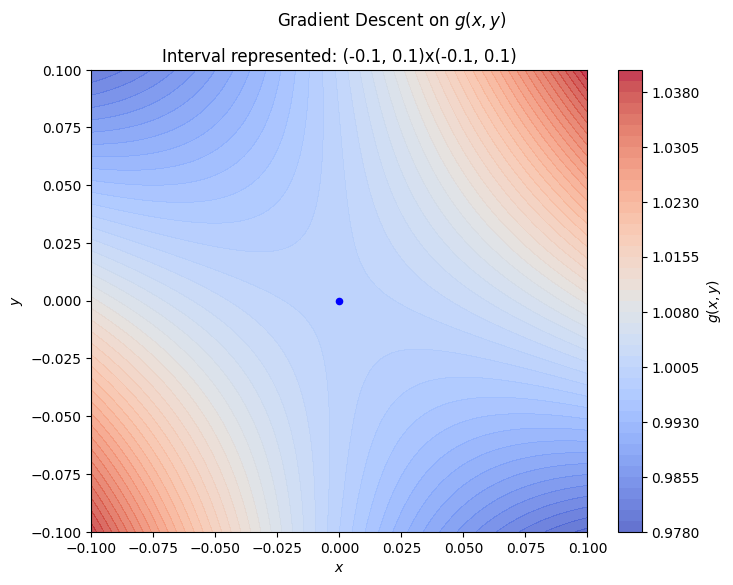

In [14]:
gradient_descent_g(np.array([0.0, 0.0]), 0.01)